## **Aplicação Modelos**

In [2]:
import sys
sys.path.append('../../')

In [3]:
import torch
from src.vfss_dataset import VFSSImageDataset
from src.data_extraction.video_frame import create_video_frame_df, load_video_frame_metadata_from_csv
from src.split_data import split_data_k_fold

from src.utils import plot_image_with_mask
from torchvision import transforms as T

from tqdm import tqdm
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np
import pandas as pd
import kornia
import cv2 as cv

from notebooks.playground_VC.unet.unet_regression import UNet
from notebooks.playground_VC.posenet.posenet import PoseNet
from torch import optim
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt

## **Inicialização**

In [4]:
videos_dir = 'C:\\Users\\vinic\\OneDrive\\Documentos\\Faculdade\\Doutorado\\Pesquisa_INCA\\vfss-data-split\\data\\videos\\' 
labels_dir = 'C:\\Users\\vinic\\OneDrive\\Documentos\\Faculdade\\Doutorado\\Pesquisa_INCA\\vfss-data-split\\data\\rotulos\\anotacoes-tecgraf\\'

# Setta o ambiente e carrega o conjunto de dados
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

video_frame_df = create_video_frame_df(
    videos_dir=videos_dir,
    labels_dir=labels_dir,
    target='points'
)

print("\nSplit Dados")
list_df_folds, df_test = split_data_k_fold(video_frame_df, test_size=0.2, n_folds=5)

# Conjunto de Teste
test_data = VFSSImageDataset(
    video_frame_df=df_test,
    target='heatmap+roi+points',
    output_dim= (256, 256)
)

Shape of attributions metadata df: (2000, 5)
Shape of label metadata df: (1361, 7)
Shape of labeled frames df: (2000, 9)

Split Dados
Folds all: 92
Test: 23
Overall Dataset - Videos: 234 | Patients: 115 | Frames: 814 (100.0%)
Training + Validation Set - Videos: 192 | Patients: 92 | Frames: 668 (82.1%)
Test Set - Videos: 42 | Patients: 23 | Frames: 146 (17.9%)

Fold 1 - Videos: 41 | Patients: 19 | Frames: 145 (17.8%)
Fold 2 - Videos: 56 | Patients: 19 | Frames: 183 (22.5%)
Fold 3 - Videos: 40 | Patients: 18 | Frames: 155 (19.0%)
Fold 4 - Videos: 26 | Patients: 18 | Frames: 95 (11.7%)
Fold 5 - Videos: 29 | Patients: 18 | Frames: 90 (11.1%)


,split_name,n_videos,n_patients,n_frames,percentage_of_initial_frames,video_ids
0,fold_1,41,19,145,0.178133,"[101, 102, 103, 104, 105, 106, 107, 108, 109, ..."
1,fold_2,56,19,183,0.224816,"[129, 130, 131, 132, 136, 137, 138, 139, 140, ..."
2,fold_3,40,18,155,0.190418,"[122, 123, 125, 126, 127, 128, 152, 153, 154, ..."
3,fold_4,26,18,95,0.116708,"[10, 113, 114, 115, 116, 117, 118, 119, 120, 1..."
4,fold_5,29,18,90,0.110565,"[192, 193, 194, 195, 196, 197, 198, 199, 200, ..."
5,test_set,42,23,146,0.179361,"[100, 11, 13, 142, 143, 144, 145, 146, 147, 14..."


torch.Size([3, 256, 256])
torch.Size([256, 256])
torch.Size([1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

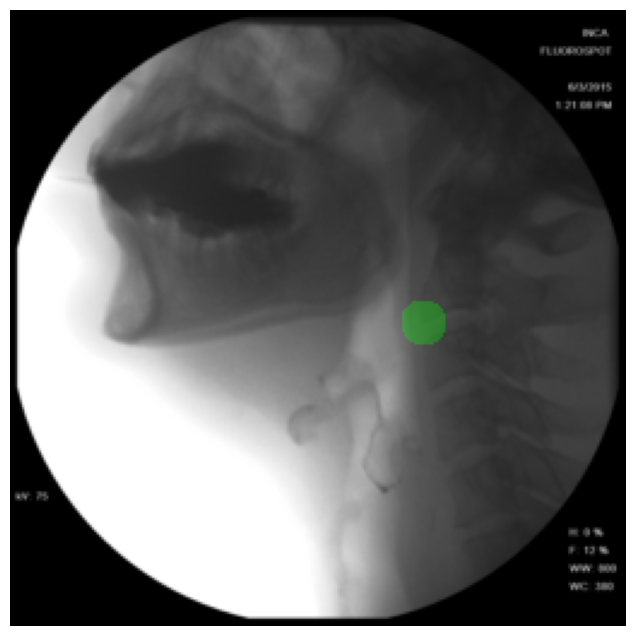

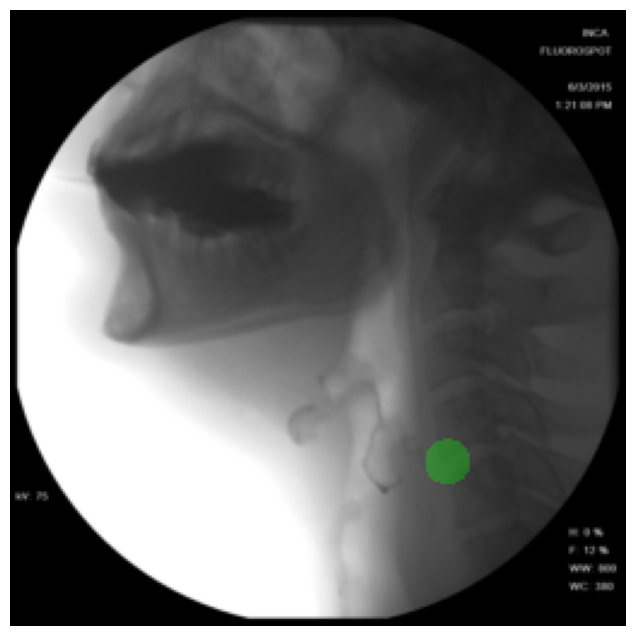

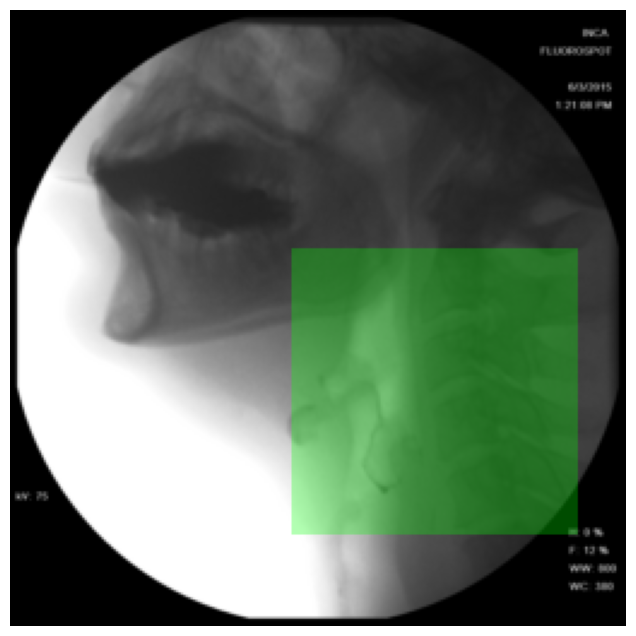

In [4]:
frame, target, meta = test_data[0]

print(frame.shape)
print(target.get('heatmap')[0].squeeze(0).shape)
print(target.get('roi').shape)

plot_image_with_mask(frame, target.get('heatmap')[0].unsqueeze(0), plot_mask=True)
plot_image_with_mask(frame, target.get('heatmap')[1].unsqueeze(0), plot_mask=True)
plot_image_with_mask(frame, target.get('roi'), plot_mask=True)

## **Treinamento da rede**

### **Geral**

In [5]:
def clahe(img):
    img_clahe = kornia.enhance.equalize_clahe(img, clip_limit = 5.0)#, clip_limit=20.0, grid_size=(8, 8))
    return img_clahe

def modify_input(img):
    # Padroniza tudo para o formato (batch, filtro, H, W)
    if (len(img.shape) != 4):
        img = img.unsqueeze(0) 
    
    # Modifica cada uma das imagens
    list_imgs = []
    n_batch = img.shape[0]
    for i in range(n_batch):
        img_orig = img[i][0] # (filtro, H, W)

        # Aplica CLAHE
        img_clahe = clahe(img_orig)

        # Aplica Double CLAHE
        img_double_clahe = clahe(img_clahe)

        # Stack Channels
        img_channels = torch.stack([img_orig, img_clahe, img_double_clahe])

        # Stack Batch
        list_imgs.append(img_channels)

    img_new = torch.stack(list_imgs, dim = 0)
    
    return img_new

In [6]:
def custom_collate_fn(batch):
    """
    batch é uma lista de tuplas: [(frame, target_dict, meta), (frame, target_dict, meta), ...]
    """
    frames = torch.stack([item[0] for item in batch])  # Empilha os inputs (frames)
    
    # Agrupa os targets por chave
    target_dicts = [item[1] for item in batch]

    batched_targets = {}
    for key in target_dicts[0].keys():
        list_aux = []
        for td in target_dicts:
            list_aux.append(td[key])
        batched_targets[key] = torch.stack(list_aux)

    # Mantém os metadados como lista
    metas = [item[2] for item in batch]

    return frames, batched_targets, metas

### **U-Net Multi-Head**

In [ ]:
def train_one_fold_unet(model, train_loader, val_loader, criterion_roi, criterion_heatmap, optimizer, device, epochs):
    model.to(device)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _ in tqdm(train_loader, desc=f"Treino Época {epoch+1}"):
            
            inputs = modify_input(inputs)
            inputs = inputs.to(device)            
            gt_heatmap = targets['heatmap'].to(device)
            gt_roi = targets['roi'].to(device)
            
            optimizer.zero_grad()
            pred_roi, pred_heatmap = model(inputs)

            # Normaliza ROI entre 0–1 (já vem com sigmoid)
            roi_mask = (pred_roi > 0.5).float()
            
            # Calcular perdas separadas
            loss_roi = criterion_roi(pred_roi, gt_roi)
            loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)
            mask_penalty = torch.mean(pred_heatmap * (1 - gt_roi)) # Penaliza pontos fora da ROI
            
            # Combinar as perdas
            loss_final = 0.4 * loss_roi + 0.5 * loss_kp + 0.1 * mask_penalty

            loss_final.backward()
            optimizer.step()
            running_loss += loss_final.item()

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, _ in val_loader:

                inputs = modify_input(inputs)
                inputs = inputs.to(device)
                gt_heatmap = targets['heatmap'].to(device)
                gt_roi = targets['roi'].to(device)
                
                pred_roi, pred_heatmap = model(inputs)
                
                loss_roi = criterion_roi(pred_roi, gt_roi)
                loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)
                mask_penalty = torch.mean(pred_heatmap * (1 - gt_roi)) # Penaliza pontos fora da ROI
            
                # Combinar as perdas
                loss_final = 0.4 * loss_roi + 0.5 * loss_kp + 0.1 * mask_penalty

                val_loss += loss_final.item()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Minha paciência acabou...")
                break
                
        print(f"Época {epoch+1}/{epochs} - Loss Treino: {running_loss/len(train_loader):.4f} - Loss Val: {val_loss/len(val_loader):.4f}")

    return model

# === Loop de K-Fold ===
def cross_validate_unet(model_class, target, output_dim, folds, criterion_roi, criterion_heatmap, optimizer_fn, device, model_save_path, epochs=10, batch_size=8, model_kwargs=None):
    
    model_kwargs = model_kwargs or {}  # se for None, vira {}
    k = len(folds)
    val_losses = []
    
    for i in range(1):
        print(f"\n===== Fold {i+1}/{k} =====")
        # Divide folds: 1 p/ validação, K-1 p/ treino
        df_val = folds[i]
        df_train = [folds[j] for j in range(k) if j != i]
        df_train = pd.concat(df_train, ignore_index=True)

        # Transformando Folds
        train_set = VFSSImageDataset(
            video_frame_df=df_train,
            target=target,
            output_dim=output_dim
            )
        
        val_set = VFSSImageDataset(
            video_frame_df=df_val,
            target=target,
            output_dim=output_dim
            )
        
        # Loaders
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        
        # Novo modelo para cada fold
        model = model_class(**model_kwargs)
        optimizer = optimizer_fn(model.parameters())
        
        # Treina o fold
        model = train_one_fold_unet(model, train_loader, val_loader, criterion_roi, criterion_heatmap, optimizer, device, epochs)
        
        # Calcula loss final de validação
        final_val_loss = 0.0
        with torch.no_grad():
            for inputs_old, targets, _ in val_loader:

                inputs = modify_input(inputs_old)
                inputs = inputs.to(device)
                gt_heatmap = targets['heatmap'].to(device)
                gt_roi = targets['roi'].to(device)
                
                pred_roi, pred_heatmap = model(inputs)
                
                loss_roi = criterion_roi(pred_roi, gt_roi)
                loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)
                mask_penalty = torch.mean(pred_heatmap * (1 - gt_roi)) # Penaliza pontos fora da ROI

                # Combinar as perdas
                loss_final = 0.4 * loss_roi + 0.5 * loss_kp + 0.1 * mask_penalty

                final_val_loss += loss_final.item()
        
        val_losses.append(final_val_loss / len(val_loader))
        
        torch.save(model.state_dict(), model_save_path + f"_fold{i+1}.pth.tar")
    
    print("\nMédia final dos folds:", np.mean(val_losses))
    return val_losses

In [8]:
model_save_path = "C:\\Users\\vinic\\OneDrive\\Documentos\\Faculdade\\Doutorado\\Pesquisa_INCA\\vfss-data-split\\data\\model_weights\\unet\\unet_checkpoint"

learning_rate = 3e-4    
batch_size = 8         # 8     -> Valor Anterior
epochs = 200            # 10   -> Valor Anterior

target = "heatmap+roi+points"      # Tem que generalizar mais a função
output_dim = (256, 256)

# Divide em treino e validação
generator = torch.Generator().manual_seed(42)

criterion_roi = nn.BCELoss() # ROI
criterion_heatmap = nn.MSELoss() # Keypoints
optimizer_fn = lambda params: optim.Adam(params, lr=1e-3)

model_kwargs = {
    "in_channels": 3,
    "num_keypoints": 2,
}

cross_validate_unet(UNet,
               target,
               output_dim,
               list_df_folds,
               criterion_roi,
               criterion_heatmap,
               optimizer_fn,
               device,
               model_save_path,
               epochs,
               batch_size,
               model_kwargs
)


===== Fold 1/5 =====


Treino Época 1: 100%|██████████| 66/66 [02:09<00:00,  1.96s/it]


Época 1/200 - Loss Treino: 0.1079 - Loss Val: 0.0733


Treino Época 2: 100%|██████████| 66/66 [02:07<00:00,  1.94s/it]


Época 2/200 - Loss Treino: 0.0551 - Loss Val: 0.0460


Treino Época 3: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 3/200 - Loss Treino: 0.0404 - Loss Val: 0.0427


Treino Época 4: 100%|██████████| 66/66 [02:05<00:00,  1.91s/it]


Época 4/200 - Loss Treino: 0.0306 - Loss Val: 0.0364


Treino Época 5: 100%|██████████| 66/66 [02:08<00:00,  1.95s/it]


Época 5/200 - Loss Treino: 0.0270 - Loss Val: 0.0440


Treino Época 6: 100%|██████████| 66/66 [02:07<00:00,  1.93s/it]


Época 6/200 - Loss Treino: 0.0217 - Loss Val: 0.0361


Treino Época 7: 100%|██████████| 66/66 [02:06<00:00,  1.91s/it]


Época 7/200 - Loss Treino: 0.0198 - Loss Val: 0.0342


Treino Época 8: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 8/200 - Loss Treino: 0.0176 - Loss Val: 0.0374


Treino Época 9: 100%|██████████| 66/66 [02:06<00:00,  1.91s/it]


Época 9/200 - Loss Treino: 0.0162 - Loss Val: 0.0318


Treino Época 10: 100%|██████████| 66/66 [02:06<00:00,  1.92s/it]


Época 10/200 - Loss Treino: 0.0142 - Loss Val: 0.0325


Treino Época 11: 100%|██████████| 66/66 [02:06<00:00,  1.92s/it]


Época 11/200 - Loss Treino: 0.0128 - Loss Val: 0.0368


Treino Época 12: 100%|██████████| 66/66 [02:08<00:00,  1.94s/it]


Época 12/200 - Loss Treino: 0.0119 - Loss Val: 0.0319


Treino Época 13: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 13/200 - Loss Treino: 0.0113 - Loss Val: 0.0301


Treino Época 14: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 14/200 - Loss Treino: 0.0096 - Loss Val: 0.0344


Treino Época 15: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 15/200 - Loss Treino: 0.0097 - Loss Val: 0.0316


Treino Época 16: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 16/200 - Loss Treino: 0.0088 - Loss Val: 0.0280


Treino Época 17: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 17/200 - Loss Treino: 0.0087 - Loss Val: 0.0303


Treino Época 18: 100%|██████████| 66/66 [02:05<00:00,  1.89s/it]


Época 18/200 - Loss Treino: 0.0084 - Loss Val: 0.0301


Treino Época 19: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 19/200 - Loss Treino: 0.0076 - Loss Val: 0.0313


Treino Época 20: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 20/200 - Loss Treino: 0.0067 - Loss Val: 0.0303


Treino Época 21: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 21/200 - Loss Treino: 0.0062 - Loss Val: 0.0301


Treino Época 22: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 22/200 - Loss Treino: 0.0054 - Loss Val: 0.0349


Treino Época 23: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 23/200 - Loss Treino: 0.0051 - Loss Val: 0.0296


Treino Época 24: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 24/200 - Loss Treino: 0.0050 - Loss Val: 0.0368


Treino Época 25: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 25/200 - Loss Treino: 0.0046 - Loss Val: 0.0343


Treino Época 26: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 26/200 - Loss Treino: 0.0041 - Loss Val: 0.0355


Treino Época 27: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 27/200 - Loss Treino: 0.0037 - Loss Val: 0.0336


Treino Época 28: 100%|██████████| 66/66 [01:59<00:00,  1.80s/it]


Época 28/200 - Loss Treino: 0.0033 - Loss Val: 0.0410


Treino Época 29: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 29/200 - Loss Treino: 0.0032 - Loss Val: 0.0334


Treino Época 30: 100%|██████████| 66/66 [01:59<00:00,  1.82s/it]


Época 30/200 - Loss Treino: 0.0030 - Loss Val: 0.0336


Treino Época 31: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 31/200 - Loss Treino: 0.0027 - Loss Val: 0.0350


Treino Época 32: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 32/200 - Loss Treino: 0.0023 - Loss Val: 0.0357


Treino Época 33: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 33/200 - Loss Treino: 0.0021 - Loss Val: 0.0338


Treino Época 34: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 34/200 - Loss Treino: 0.0020 - Loss Val: 0.0389


Treino Época 35: 100%|██████████| 66/66 [02:09<00:00,  1.96s/it]


Época 35/200 - Loss Treino: 0.0024 - Loss Val: 0.0361


Treino Época 36: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 36/200 - Loss Treino: 0.0017 - Loss Val: 0.0371


Treino Época 37: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 37/200 - Loss Treino: 0.0018 - Loss Val: 0.0476


Treino Época 38: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 38/200 - Loss Treino: 0.0135 - Loss Val: 0.0347


Treino Época 39: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 39/200 - Loss Treino: 0.0052 - Loss Val: 0.0357


Treino Época 40: 100%|██████████| 66/66 [01:59<00:00,  1.82s/it]


Época 40/200 - Loss Treino: 0.0026 - Loss Val: 0.0352


Treino Época 41: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 41/200 - Loss Treino: 0.0020 - Loss Val: 0.0364


Treino Época 42: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 42/200 - Loss Treino: 0.0012 - Loss Val: 0.0399


Treino Época 43: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 43/200 - Loss Treino: 0.0009 - Loss Val: 0.0431


Treino Época 44: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 44/200 - Loss Treino: 0.0008 - Loss Val: 0.0398


Treino Época 45: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 45/200 - Loss Treino: 0.0006 - Loss Val: 0.0355


Treino Época 46: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 46/200 - Loss Treino: 0.0005 - Loss Val: 0.0388


Treino Época 47: 100%|██████████| 66/66 [01:57<00:00,  1.79s/it]


Época 47/200 - Loss Treino: 0.0007 - Loss Val: 0.0399


Treino Época 48: 100%|██████████| 66/66 [01:50<00:00,  1.68s/it]


Época 48/200 - Loss Treino: 0.0008 - Loss Val: 0.0385


Treino Época 49: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 49/200 - Loss Treino: 0.0008 - Loss Val: 0.0375


Treino Época 50: 100%|██████████| 66/66 [02:07<00:00,  1.93s/it]


Época 50/200 - Loss Treino: 0.0005 - Loss Val: 0.0408


Treino Época 51: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 51/200 - Loss Treino: 0.0001 - Loss Val: 0.0425


Treino Época 52: 100%|██████████| 66/66 [02:08<00:00,  1.94s/it]


Época 52/200 - Loss Treino: 0.0001 - Loss Val: 0.0413


Treino Época 53: 100%|██████████| 66/66 [02:07<00:00,  1.92s/it]


Época 53/200 - Loss Treino: 0.0002 - Loss Val: 0.0402


Treino Época 54: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 54/200 - Loss Treino: 0.0001 - Loss Val: 0.0429


Treino Época 55: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 55/200 - Loss Treino: 0.0000 - Loss Val: 0.0429


Treino Época 56: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 56/200 - Loss Treino: -0.0002 - Loss Val: 0.0401


Treino Época 57: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 57/200 - Loss Treino: -0.0004 - Loss Val: 0.0441


Treino Época 58: 100%|██████████| 66/66 [02:15<00:00,  2.05s/it]


Época 58/200 - Loss Treino: -0.0000 - Loss Val: 0.0425


Treino Época 59: 100%|██████████| 66/66 [02:06<00:00,  1.91s/it]


Época 59/200 - Loss Treino: -0.0002 - Loss Val: 0.0398


Treino Época 60: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 60/200 - Loss Treino: -0.0003 - Loss Val: 0.0423


Treino Época 61: 100%|██████████| 66/66 [01:56<00:00,  1.76s/it]


Época 61/200 - Loss Treino: -0.0004 - Loss Val: 0.0407


Treino Época 62: 100%|██████████| 66/66 [01:56<00:00,  1.76s/it]


Época 62/200 - Loss Treino: -0.0005 - Loss Val: 0.0470


Treino Época 63: 100%|██████████| 66/66 [01:55<00:00,  1.74s/it]


Época 63/200 - Loss Treino: -0.0005 - Loss Val: 0.0440


Treino Época 64: 100%|██████████| 66/66 [01:57<00:00,  1.78s/it]


Época 64/200 - Loss Treino: -0.0005 - Loss Val: 0.0447


Treino Época 65: 100%|██████████| 66/66 [01:55<00:00,  1.75s/it]


Época 65/200 - Loss Treino: -0.0006 - Loss Val: 0.0478


Treino Época 66: 100%|██████████| 66/66 [01:55<00:00,  1.76s/it]


Época 66/200 - Loss Treino: -0.0004 - Loss Val: 0.0410


Treino Época 67: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 67/200 - Loss Treino: -0.0004 - Loss Val: 0.0404


Treino Época 68: 100%|██████████| 66/66 [02:07<00:00,  1.94s/it]


Época 68/200 - Loss Treino: -0.0004 - Loss Val: 0.0418


Treino Época 69: 100%|██████████| 66/66 [01:53<00:00,  1.73s/it]


Época 69/200 - Loss Treino: -0.0004 - Loss Val: 0.0446


Treino Época 70: 100%|██████████| 66/66 [01:53<00:00,  1.72s/it]


Época 70/200 - Loss Treino: -0.0006 - Loss Val: 0.0443


Treino Época 71: 100%|██████████| 66/66 [02:14<00:00,  2.04s/it]


Época 71/200 - Loss Treino: -0.0006 - Loss Val: 0.0452


Treino Época 72: 100%|██████████| 66/66 [02:08<00:00,  1.94s/it]


Época 72/200 - Loss Treino: -0.0006 - Loss Val: 0.0441


Treino Época 73: 100%|██████████| 66/66 [02:09<00:00,  1.97s/it]


Época 73/200 - Loss Treino: -0.0004 - Loss Val: 0.0410


Treino Época 74: 100%|██████████| 66/66 [02:18<00:00,  2.10s/it]


Época 74/200 - Loss Treino: -0.0005 - Loss Val: 0.0427


Treino Época 75: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 75/200 - Loss Treino: -0.0006 - Loss Val: 0.0432


Treino Época 76: 100%|██████████| 66/66 [01:57<00:00,  1.78s/it]


Época 76/200 - Loss Treino: -0.0005 - Loss Val: 0.0491


Treino Época 77: 100%|██████████| 66/66 [01:55<00:00,  1.76s/it]


Época 77/200 - Loss Treino: -0.0005 - Loss Val: 0.0470


Treino Época 78: 100%|██████████| 66/66 [01:58<00:00,  1.80s/it]


Época 78/200 - Loss Treino: -0.0005 - Loss Val: 0.0456


Treino Época 79: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 79/200 - Loss Treino: -0.0008 - Loss Val: 0.0483


Treino Época 80: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 80/200 - Loss Treino: -0.0007 - Loss Val: 0.0440


Treino Época 81: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 81/200 - Loss Treino: -0.0009 - Loss Val: 0.0479


Treino Época 82: 100%|██████████| 66/66 [01:59<00:00,  1.82s/it]


Época 82/200 - Loss Treino: -0.0010 - Loss Val: 0.0483


Treino Época 83: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 83/200 - Loss Treino: -0.0009 - Loss Val: 0.0440


Treino Época 84: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 84/200 - Loss Treino: -0.0007 - Loss Val: 0.0470


Treino Época 85: 100%|██████████| 66/66 [01:57<00:00,  1.78s/it]


Época 85/200 - Loss Treino: -0.0009 - Loss Val: 0.0458


Treino Época 86: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 86/200 - Loss Treino: -0.0008 - Loss Val: 0.0484


Treino Época 87: 100%|██████████| 66/66 [02:07<00:00,  1.93s/it]


Época 87/200 - Loss Treino: -0.0008 - Loss Val: 0.0423


Treino Época 88: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 88/200 - Loss Treino: -0.0009 - Loss Val: 0.0498


Treino Época 89: 100%|██████████| 66/66 [01:58<00:00,  1.79s/it]


Época 89/200 - Loss Treino: -0.0010 - Loss Val: 0.0472


Treino Época 90: 100%|██████████| 66/66 [01:58<00:00,  1.80s/it]


Época 90/200 - Loss Treino: -0.0011 - Loss Val: 0.0450


Treino Época 91: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 91/200 - Loss Treino: -0.0010 - Loss Val: 0.0518


Treino Época 92: 100%|██████████| 66/66 [01:58<00:00,  1.80s/it]


Época 92/200 - Loss Treino: -0.0010 - Loss Val: 0.0517


Treino Época 93: 100%|██████████| 66/66 [01:58<00:00,  1.79s/it]


Época 93/200 - Loss Treino: -0.0011 - Loss Val: 0.0471


Treino Época 94: 100%|██████████| 66/66 [01:58<00:00,  1.79s/it]


Época 94/200 - Loss Treino: -0.0010 - Loss Val: 0.0461


Treino Época 95: 100%|██████████| 66/66 [01:58<00:00,  1.80s/it]


Época 95/200 - Loss Treino: -0.0011 - Loss Val: 0.0467


Treino Época 96: 100%|██████████| 66/66 [01:59<00:00,  1.82s/it]


Época 96/200 - Loss Treino: -0.0011 - Loss Val: 0.0472


Treino Época 97: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 97/200 - Loss Treino: -0.0012 - Loss Val: 0.0468


Treino Época 98: 100%|██████████| 66/66 [01:59<00:00,  1.81s/it]


Época 98/200 - Loss Treino: -0.0011 - Loss Val: 0.0505


Treino Época 99: 100%|██████████| 66/66 [01:59<00:00,  1.81s/it]


Época 99/200 - Loss Treino: -0.0011 - Loss Val: 0.0493


Treino Época 100: 100%|██████████| 66/66 [01:59<00:00,  1.81s/it]


Época 100/200 - Loss Treino: -0.0010 - Loss Val: 0.0495


Treino Época 101: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 101/200 - Loss Treino: -0.0011 - Loss Val: 0.0499


Treino Época 102: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 102/200 - Loss Treino: -0.0011 - Loss Val: 0.0491


Treino Época 103: 100%|██████████| 66/66 [01:59<00:00,  1.81s/it]


Época 103/200 - Loss Treino: -0.0011 - Loss Val: 0.0491


Treino Época 104: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 104/200 - Loss Treino: -0.0013 - Loss Val: 0.0511


Treino Época 105: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 105/200 - Loss Treino: -0.0013 - Loss Val: 0.0445


Treino Época 106: 100%|██████████| 66/66 [01:59<00:00,  1.81s/it]


Época 106/200 - Loss Treino: -0.0013 - Loss Val: 0.0494


Treino Época 107: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 107/200 - Loss Treino: -0.0012 - Loss Val: 0.0508


Treino Época 108: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 108/200 - Loss Treino: -0.0012 - Loss Val: 0.0538


Treino Época 109: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 109/200 - Loss Treino: -0.0011 - Loss Val: 0.0506


Treino Época 110: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 110/200 - Loss Treino: -0.0011 - Loss Val: 0.0505


Treino Época 111: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 111/200 - Loss Treino: -0.0013 - Loss Val: 0.0523


Treino Época 112: 100%|██████████| 66/66 [02:00<00:00,  1.82s/it]


Época 112/200 - Loss Treino: -0.0011 - Loss Val: 0.0505


Treino Época 113: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 113/200 - Loss Treino: -0.0016 - Loss Val: 0.0498


Treino Época 114: 100%|██████████| 66/66 [02:01<00:00,  1.83s/it]


Época 114/200 - Loss Treino: -0.0015 - Loss Val: 0.0543


Treino Época 115: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 115/200 - Loss Treino: -0.0014 - Loss Val: 0.0507


Treino Época 116: 100%|██████████| 66/66 [02:01<00:00,  1.83s/it]


Época 116/200 - Loss Treino: -0.0013 - Loss Val: 0.0549


Treino Época 117: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 117/200 - Loss Treino: -0.0015 - Loss Val: 0.0508


Treino Época 118: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 118/200 - Loss Treino: -0.0015 - Loss Val: 0.0532


Treino Época 119: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 119/200 - Loss Treino: -0.0013 - Loss Val: 0.0566


Treino Época 120: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 120/200 - Loss Treino: -0.0016 - Loss Val: 0.0522


Treino Época 121: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 121/200 - Loss Treino: -0.0015 - Loss Val: 0.0523


Treino Época 122: 100%|██████████| 66/66 [02:01<00:00,  1.83s/it]


Época 122/200 - Loss Treino: -0.0015 - Loss Val: 0.0539


Treino Época 123: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 123/200 - Loss Treino: -0.0016 - Loss Val: 0.0547


Treino Época 124: 100%|██████████| 66/66 [02:01<00:00,  1.83s/it]


Época 124/200 - Loss Treino: -0.0017 - Loss Val: 0.0553


Treino Época 125: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 125/200 - Loss Treino: -0.0017 - Loss Val: 0.0588


Treino Época 126: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 126/200 - Loss Treino: -0.0016 - Loss Val: 0.0509


Treino Época 127: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 127/200 - Loss Treino: -0.0015 - Loss Val: 0.0518


Treino Época 128: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 128/200 - Loss Treino: -0.0013 - Loss Val: 0.0491


Treino Época 129: 100%|██████████| 66/66 [02:00<00:00,  1.83s/it]


Época 129/200 - Loss Treino: -0.0015 - Loss Val: 0.0505


Treino Época 130: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 130/200 - Loss Treino: -0.0018 - Loss Val: 0.0541


Treino Época 131: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 131/200 - Loss Treino: -0.0017 - Loss Val: 0.0539


Treino Época 132: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 132/200 - Loss Treino: -0.0017 - Loss Val: 0.0563


Treino Época 133: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 133/200 - Loss Treino: -0.0017 - Loss Val: 0.0558


Treino Época 134: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 134/200 - Loss Treino: -0.0018 - Loss Val: 0.0575


Treino Época 135: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 135/200 - Loss Treino: -0.0017 - Loss Val: 0.0593


Treino Época 136: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 136/200 - Loss Treino: -0.0016 - Loss Val: 0.0542


Treino Época 137: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 137/200 - Loss Treino: -0.0018 - Loss Val: 0.0579


Treino Época 138: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 138/200 - Loss Treino: -0.0017 - Loss Val: 0.0531


Treino Época 139: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 139/200 - Loss Treino: -0.0015 - Loss Val: 0.0559


Treino Época 140: 100%|██████████| 66/66 [02:01<00:00,  1.85s/it]


Época 140/200 - Loss Treino: -0.0017 - Loss Val: 0.0597


Treino Época 141: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 141/200 - Loss Treino: -0.0016 - Loss Val: 0.0559


Treino Época 142: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 142/200 - Loss Treino: -0.0017 - Loss Val: 0.0581


Treino Época 143: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 143/200 - Loss Treino: -0.0019 - Loss Val: 0.0625


Treino Época 144: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 144/200 - Loss Treino: -0.0019 - Loss Val: 0.0555


Treino Época 145: 100%|██████████| 66/66 [02:02<00:00,  1.85s/it]


Época 145/200 - Loss Treino: -0.0019 - Loss Val: 0.0544


Treino Época 146: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 146/200 - Loss Treino: -0.0018 - Loss Val: 0.0619


Treino Época 147: 100%|██████████| 66/66 [02:01<00:00,  1.84s/it]


Época 147/200 - Loss Treino: -0.0013 - Loss Val: 0.0509


Treino Época 148: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 148/200 - Loss Treino: -0.0013 - Loss Val: 0.0573


Treino Época 149: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 149/200 - Loss Treino: -0.0018 - Loss Val: 0.0587


Treino Época 150: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 150/200 - Loss Treino: -0.0017 - Loss Val: 0.0575


Treino Época 151: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 151/200 - Loss Treino: -0.0019 - Loss Val: 0.0572


Treino Época 152: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 152/200 - Loss Treino: -0.0019 - Loss Val: 0.0552


Treino Época 153: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 153/200 - Loss Treino: -0.0020 - Loss Val: 0.0578


Treino Época 154: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 154/200 - Loss Treino: -0.0020 - Loss Val: 0.0627


Treino Época 155: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 155/200 - Loss Treino: -0.0021 - Loss Val: 0.0643


Treino Época 156: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 156/200 - Loss Treino: -0.0021 - Loss Val: 0.0578


Treino Época 157: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 157/200 - Loss Treino: -0.0020 - Loss Val: 0.0598


Treino Época 158: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 158/200 - Loss Treino: -0.0019 - Loss Val: 0.0588


Treino Época 159: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 159/200 - Loss Treino: -0.0018 - Loss Val: 0.0576


Treino Época 160: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 160/200 - Loss Treino: -0.0019 - Loss Val: 0.0553


Treino Época 161: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 161/200 - Loss Treino: -0.0019 - Loss Val: 0.0561


Treino Época 162: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 162/200 - Loss Treino: -0.0020 - Loss Val: 0.0553


Treino Época 163: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 163/200 - Loss Treino: -0.0021 - Loss Val: 0.0635


Treino Época 164: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 164/200 - Loss Treino: -0.0021 - Loss Val: 0.0586


Treino Época 165: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 165/200 - Loss Treino: -0.0021 - Loss Val: 0.0670


Treino Época 166: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 166/200 - Loss Treino: -0.0020 - Loss Val: 0.0586


Treino Época 167: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 167/200 - Loss Treino: -0.0021 - Loss Val: 0.0601


Treino Época 168: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 168/200 - Loss Treino: -0.0020 - Loss Val: 0.0629


Treino Época 169: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 169/200 - Loss Treino: -0.0013 - Loss Val: 0.0582


Treino Época 170: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 170/200 - Loss Treino: -0.0019 - Loss Val: 0.0613


Treino Época 171: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 171/200 - Loss Treino: -0.0018 - Loss Val: 0.0543


Treino Época 172: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 172/200 - Loss Treino: -0.0020 - Loss Val: 0.0579


Treino Época 173: 100%|██████████| 66/66 [02:02<00:00,  1.86s/it]


Época 173/200 - Loss Treino: -0.0021 - Loss Val: 0.0651


Treino Época 174: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 174/200 - Loss Treino: -0.0022 - Loss Val: 0.0596


Treino Época 175: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 175/200 - Loss Treino: -0.0021 - Loss Val: 0.0615


Treino Época 176: 100%|██████████| 66/66 [02:03<00:00,  1.86s/it]


Época 176/200 - Loss Treino: -0.0022 - Loss Val: 0.0625


Treino Época 177: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 177/200 - Loss Treino: -0.0022 - Loss Val: 0.0645


Treino Época 178: 100%|██████████| 66/66 [02:03<00:00,  1.88s/it]


Época 178/200 - Loss Treino: -0.0023 - Loss Val: 0.0644


Treino Época 179: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 179/200 - Loss Treino: -0.0022 - Loss Val: 0.0674


Treino Época 180: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 180/200 - Loss Treino: -0.0021 - Loss Val: 0.0659


Treino Época 181: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 181/200 - Loss Treino: -0.0022 - Loss Val: 0.0610


Treino Época 182: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 182/200 - Loss Treino: -0.0022 - Loss Val: 0.0636


Treino Época 183: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 183/200 - Loss Treino: -0.0022 - Loss Val: 0.0695


Treino Época 184: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 184/200 - Loss Treino: -0.0022 - Loss Val: 0.0630


Treino Época 185: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 185/200 - Loss Treino: -0.0022 - Loss Val: 0.0639


Treino Época 186: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 186/200 - Loss Treino: -0.0023 - Loss Val: 0.0638


Treino Época 187: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 187/200 - Loss Treino: -0.0023 - Loss Val: 0.0634


Treino Época 188: 100%|██████████| 66/66 [02:05<00:00,  1.90s/it]


Época 188/200 - Loss Treino: -0.0023 - Loss Val: 0.0639


Treino Época 189: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 189/200 - Loss Treino: -0.0021 - Loss Val: 0.0589


Treino Época 190: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 190/200 - Loss Treino: -0.0022 - Loss Val: 0.0616


Treino Época 191: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 191/200 - Loss Treino: -0.0023 - Loss Val: 0.0665


Treino Época 192: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 192/200 - Loss Treino: -0.0023 - Loss Val: 0.0682


Treino Época 193: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 193/200 - Loss Treino: -0.0023 - Loss Val: 0.0654


Treino Época 194: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 194/200 - Loss Treino: -0.0024 - Loss Val: 0.0705


Treino Época 195: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 195/200 - Loss Treino: -0.0019 - Loss Val: 0.0611


Treino Época 196: 100%|██████████| 66/66 [02:04<00:00,  1.88s/it]


Época 196/200 - Loss Treino: -0.0023 - Loss Val: 0.0666


Treino Época 197: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 197/200 - Loss Treino: -0.0024 - Loss Val: 0.0656


Treino Época 198: 100%|██████████| 66/66 [02:03<00:00,  1.87s/it]


Época 198/200 - Loss Treino: -0.0024 - Loss Val: 0.0711


Treino Época 199: 100%|██████████| 66/66 [02:04<00:00,  1.89s/it]


Época 199/200 - Loss Treino: -0.0024 - Loss Val: 0.0676


Treino Época 200: 100%|██████████| 66/66 [02:05<00:00,  1.89s/it]


Época 200/200 - Loss Treino: -0.0023 - Loss Val: 0.0684

Média final dos folds: 0.0684081762048759


[0.0684081762048759]

### **PoseNet**

In [ ]:
def train_one_fold_posenet(model, train_loader, val_loader, criterion_heatmap, optimizer, device, epochs):
    model.to(device)

    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets, _ in tqdm(train_loader, desc=f"Treino Época {epoch+1}"):

            inputs = modify_input(inputs)
            inputs = inputs.to(device)
            gt_heatmap = targets['heatmap'].to(device)

            optimizer.zero_grad()
            pred_heatmap = model(inputs)

            loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)

            loss_kp.backward()
            optimizer.step()
            running_loss += loss_kp.item()

        # Validação
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, _ in val_loader:

                inputs = modify_input(inputs)
                inputs = inputs.to(device)
                gt_heatmap = targets['heatmap'].to(device)

                pred_heatmap = model(inputs)
                
                loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)
                val_loss += loss_kp.item()

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Minha paciência acabou...")
                break
                
        print(f"Época {epoch+1}/{epochs} - Loss Treino: {running_loss/len(train_loader):.4f} - Loss Val: {val_loss/len(val_loader):.4f}")

    return model

# === Loop de K-Fold ===
def cross_validate_posenet(model_class, target, output_dim, folds, criterion_heatmap, optimizer_fn, device, model_save_path, epochs=10, batch_size=8, model_kwargs=None):
    
    model_kwargs = model_kwargs or {}  # se for None, vira {}
    k = len(folds)
    val_losses = []
    
    for i in range(1):
        print(f"\n===== Fold {i+1}/{k} =====")
        # Divide folds: 1 p/ validação, K-1 p/ treino
        df_val = folds[i]
        df_train = [folds[j] for j in range(k) if j != i]
        df_train = pd.concat(df_train, ignore_index=True)

        # Transformando Folds
        train_set = VFSSImageDataset(
            video_frame_df=df_train,
            target=target,
            output_dim=output_dim
            )
        
        val_set = VFSSImageDataset(
            video_frame_df=df_val,
            target=target,
            output_dim=output_dim
            )
        
        # Loaders
        train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)
        
        # Novo modelo para cada fold
        model = model_class(**model_kwargs)
        optimizer = optimizer_fn(model.parameters())
        
        # Treina o fold
        model = train_one_fold_posenet(model, train_loader, val_loader, criterion_heatmap, optimizer, device, epochs)
        
        # Calcula loss final de validação
        final_val_loss = 0.0
        with torch.no_grad():
            for inputs, targets, _ in val_loader:

                inputs = modify_input(inputs)
                inputs = inputs.to(device)
                gt_heatmap = targets['heatmap'].to(device)
                
                pred_heatmap = model(inputs)
                
                loss_kp = criterion_heatmap(pred_heatmap, gt_heatmap)        
                final_val_loss += loss_kp.item()
        
        val_losses.append(final_val_loss / len(val_loader))
        
        torch.save(model.state_dict(), model_save_path + f"_fold{i+1}.pth.tar")
    
    print("\nMédia final dos folds:", np.mean(val_losses))
    return val_losses

In [10]:
model_save_path = "C:\\Users\\vinic\\OneDrive\\Documentos\\Faculdade\\Doutorado\\Pesquisa_INCA\\vfss-data-split\\data\\model_weights\\posenet\\posenet_checkpoint"

learning_rate = 3e-4
batch_size = 8         # 8     -> Valor Anterior
epochs = 200            # 100   -> Valor Anterior

target = "heatmap+roi+points"      # Tem que generalizar mais a função
output_dim = (256, 256)

# Divide em treino e validação
generator = torch.Generator().manual_seed(42)

criterion_heatmap = nn.MSELoss() # Keypoints
optimizer_fn = lambda params: optim.Adam(params, lr=1e-3)

model_kwargs = {
    "num_keypoints": 2,
}

cross_validate_posenet(PoseNet,
               target,
               output_dim,
               list_df_folds,
               criterion_heatmap,
               optimizer_fn,
               device,
               model_save_path,
               epochs,
               batch_size,
               model_kwargs
)


===== Fold 1/5 =====


Treino Época 1: 100%|██████████| 66/66 [01:47<00:00,  1.62s/it]


Época 1/200 - Loss Treino: 0.0929 - Loss Val: 0.0026


Treino Época 2: 100%|██████████| 66/66 [01:43<00:00,  1.58s/it]


Época 2/200 - Loss Treino: 0.0012 - Loss Val: 0.0009


Treino Época 3: 100%|██████████| 66/66 [01:43<00:00,  1.57s/it]


Época 3/200 - Loss Treino: 0.0008 - Loss Val: 0.0007


Treino Época 4: 100%|██████████| 66/66 [01:43<00:00,  1.56s/it]


Época 4/200 - Loss Treino: 0.0007 - Loss Val: 0.0007


Treino Época 5: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 5/200 - Loss Treino: 0.0006 - Loss Val: 0.0007


Treino Época 6: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 6/200 - Loss Treino: 0.0006 - Loss Val: 0.0006


Treino Época 7: 100%|██████████| 66/66 [01:43<00:00,  1.56s/it]


Época 7/200 - Loss Treino: 0.0006 - Loss Val: 0.0005


Treino Época 8: 100%|██████████| 66/66 [01:42<00:00,  1.56s/it]


Época 8/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 9: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 9/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 10: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 10/200 - Loss Treino: 0.0005 - Loss Val: 0.0006


Treino Época 11: 100%|██████████| 66/66 [01:41<00:00,  1.54s/it]


Época 11/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 12: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 12/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 13: 100%|██████████| 66/66 [01:44<00:00,  1.58s/it]


Época 13/200 - Loss Treino: 0.0005 - Loss Val: 0.0004


Treino Época 14: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 14/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 15: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 15/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 16: 100%|██████████| 66/66 [01:42<00:00,  1.56s/it]


Época 16/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 17: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]


Época 17/200 - Loss Treino: 0.0005 - Loss Val: 0.0005


Treino Época 18: 100%|██████████| 66/66 [01:42<00:00,  1.55s/it]



Média final dos folds: 0.00042689312096244017


[0.00042689312096244017]

## **Conjunto de Teste**

In [14]:
def visualizacao_resultados_teste_unet(test_data, model_class, model_kwargs, model_path, path_figure, criterion, device):
    '''
    Mostra melhor, pior e mediana das visualizações considerando uma métrica específica
        test_data : VFSSImageDataset com os daddos de teste
        model : caminho do modelo a ser testado
        criterion : forma que avaliaremos o modelo
    '''

    # Inicializa o modelo
    model_kwargs = model_kwargs or {}
    model = model_class(**model_kwargs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    # Calula a loss com o criterio especifico para cada item do conjunto
    list_loss = [[] for _ in range(model_kwargs['num_keypoints'])]
    for input, target, _ in test_data:
        
        input = modify_input(input)
        input = input.float().to(device)
        gt_roi = target['roi'].float().to(device)
        gt_heatmap = target['heatmap'].float().to(device)
        
        with torch.no_grad():
            pred_roi, pred_heatmap = model(input)
        pred_heatmap = pred_heatmap.squeeze(0)
        
        # No futuro, pra generalizar essa parte pode ser uma função,
        # em que definimos a forma que o critério é calculado.

        # Os pontos são dados em coordenadas invertidas (y, x), mas isso não muda a distância
        gt_points = torch.Tensor(
            [np.unravel_index(np.argmax(gt_heatmap[k].cpu().numpy()),gt_heatmap[k].shape) \
                for k in range(model_kwargs['num_keypoints'])]
            )
        pred_points = torch.Tensor(
            [np.unravel_index(np.argmax(pred_heatmap[k].cpu().numpy()),pred_heatmap[k].shape) \
                for k in range(model_kwargs['num_keypoints'])]
            )
        
        for i in range(model_kwargs['num_keypoints']):
            loss = criterion(gt_points[i], pred_points[i])
            list_loss[i].append(loss)
        # ======== Até aqui estaria na função
        
    list_loss = np.array(list_loss)

    # Graficos para ponto:
    for i in range(model_kwargs['num_keypoints']):
        # mínimo e índice
        idx_min = np.argmin(list_loss[i])
        val_min = list_loss[i][idx_min]
        
        # mediana e índice
        val_med = np.quantile(list_loss[i], 0.5, method='lower')
        idx_med = np.where(list_loss[i] == val_med)[0][0]
        
        # máximo e índice
        idx_max = np.argmax(list_loss[i])
        val_max = list_loss[i][idx_max]

        list_idx = [idx_min, idx_med, idx_max]
        list_val = [val_min, val_med, val_max]
        titles = ["Min Loss", "Median Loss", "Max Loss"]

        # Montando Gráfico:
        path_final = path_figure + f"_point{i+1}.png"
        fig, axs = plt.subplots(1, len(list_idx), figsize=(4*len(list_idx), 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.15)

        for j in range(len(list_idx)):
            ax = axs[j]
            idx = list_idx[j]
            dt = test_data[idx]
            input = dt[0].float().to(device)
            input = modify_input(input)
            gt_heatmap = dt[1]['heatmap']

            with torch.no_grad():
                _, pred_heatmap = model(input)
            pred_heatmap = pred_heatmap.squeeze(0)

            gt_points = torch.Tensor(
                np.unravel_index(np.argmax(gt_heatmap[i].cpu().numpy()),gt_heatmap[i].shape))
            pred_points = torch.Tensor(
                np.unravel_index(np.argmax(pred_heatmap[i].cpu().numpy()),pred_heatmap[i].shape))

            # Imagem
            ax.imshow(input.squeeze(0)[0].detach().cpu().numpy(), cmap='gray')
            ax.set_title(titles[j] + " - " + str(list_val[j]))
            ax.axis('off')

            # Ground Truth
            ax.scatter(gt_points[1], gt_points[0], color='lime', marker='x', s=10, label = "GT")
            # Predictions
            ax.scatter(pred_points[1], pred_points[0], color='red', marker='o', s=5, label = "Pred")
        
        plt.legend()
        plt.tight_layout()
        plt.savefig(path_final)
        plt.show()

In [15]:
def visualizacao_resultados_teste_posenet(test_data, model_class, model_kwargs, model_path, path_figure, criterion, device):
    '''
    Mostra melhor, pior e mediana das visualizações considerando uma métrica específica
        test_data : VFSSImageDataset com os daddos de teste
        model : caminho do modelo a ser testado
        criterion : forma que avaliaremos o modelo
    '''

    # Inicializa o modelo
    model_kwargs = model_kwargs or {}
    model = model_class(**model_kwargs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
    model.eval()

    # Calula a loss com o criterio especifico para cada item do conjunto
    list_loss = [[] for _ in range(model_kwargs['num_keypoints'])]
    for input, target, _ in test_data:

        input = modify_input(input)
        input = input.float().to(device)
        gt_heatmap = target['heatmap'].float().to(device)
        
        with torch.no_grad():
            pred_heatmap = model(input)
        pred_heatmap = pred_heatmap.squeeze(0)
        
        # No futuro, pra generalizar essa parte pode ser uma função,
        # em que definimos a forma que o critério é calculado.

        # Os pontos são dados em coordenadas invertidas (y, x), mas isso não muda a distância
        gt_points = torch.Tensor(
            [np.unravel_index(np.argmax(gt_heatmap[k].cpu().numpy()),gt_heatmap[k].shape) \
                for k in range(model_kwargs['num_keypoints'])]
            )
        pred_points = torch.Tensor(
            [np.unravel_index(np.argmax(pred_heatmap[k].cpu().numpy()),pred_heatmap[k].shape) \
                for k in range(model_kwargs['num_keypoints'])]
            )
        
        for i in range(model_kwargs['num_keypoints']):
            loss = criterion(gt_points[i], pred_points[i])
            list_loss[i].append(loss)
        # ======== Até aqui estaria na função
        
    list_loss = np.array(list_loss)

    # Graficos para ponto:
    for i in range(model_kwargs['num_keypoints']):
        # mínimo e índice
        idx_min = np.argmin(list_loss[i])
        val_min = list_loss[i][idx_min]
        
        # mediana e índice
        val_med = np.quantile(list_loss[i], 0.5, method='lower')
        idx_med = np.where(list_loss[i] == val_med)[0][0]
        
        # máximo e índice
        idx_max = np.argmax(list_loss[i])
        val_max = list_loss[i][idx_max]

        list_idx = [idx_min, idx_med, idx_max]
        list_val = [val_min, val_med, val_max]
        titles = ["Min Loss", "Median Loss", "Max Loss"]

        # Montando Gráfico:
        path_final = path_figure + f"_point{i+1}.png"
        fig, axs = plt.subplots(1, len(list_idx), figsize=(4*len(list_idx), 4))
        plt.subplots_adjust(wspace=0.1, hspace=0.15)

        for j in range(len(list_idx)):
            ax = axs[j]
            idx = list_idx[j]
            dt = test_data[idx]
            input = dt[0].float().to(device)
            input = modify_input(input)
            gt_heatmap = dt[1]['heatmap']

            with torch.no_grad():
                pred_heatmap = model(input)
            pred_heatmap = pred_heatmap.squeeze(0)

            gt_points = torch.Tensor(
                np.unravel_index(np.argmax(gt_heatmap[i].cpu().numpy()),gt_heatmap[i].shape))
            pred_points = torch.Tensor(
                np.unravel_index(np.argmax(pred_heatmap[i].cpu().numpy()),pred_heatmap[i].shape))

            # Imagem
            ax.imshow(input.squeeze(0)[0].detach().cpu().numpy(), cmap='gray')
            ax.set_title(titles[j] + " - " + str(list_val[j]))
            ax.axis('off')

            # Ground Truth
            ax.scatter(gt_points[1], gt_points[0], color='lime', marker='x', s=10, label = "GT")
            # Predictions
            ax.scatter(pred_points[1], pred_points[0], color='red', marker='o', s=5, label = "Pred")
        
        plt.legend()
        plt.tight_layout()
        plt.savefig(path_final)
        plt.show()

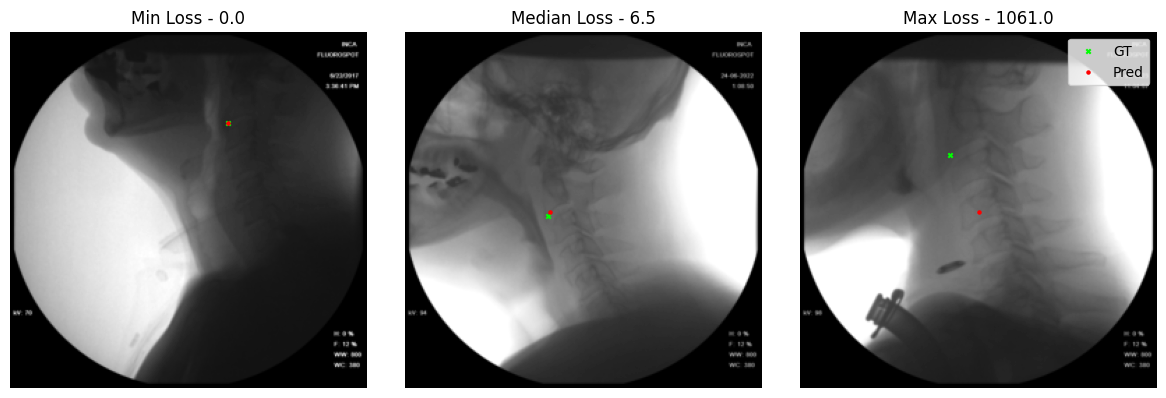

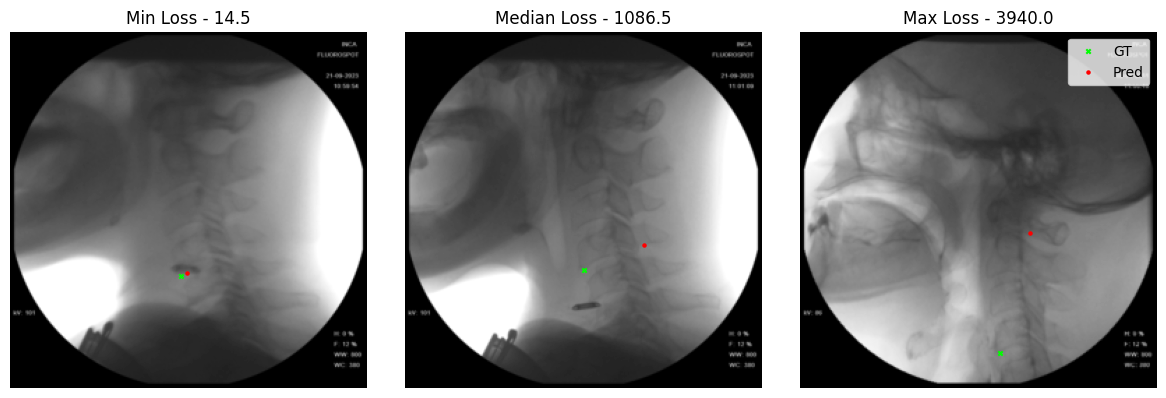

In [17]:
# Teste - U-Net MultiHead
for i in range(1):
    model_path = f"..\\..\\data\\model_weights\\unet\\unet_checkpoint_fold{i+1}.pth.tar"
    path_figure = f"..\\..\\data\\vis\\unet\\fold{i+1}"
    criterion = nn.MSELoss()
    model_kwargs = {
        "in_channels": 3,
        "num_keypoints": 2,
    }
    visualizacao_resultados_teste_unet(test_data = test_data,
                                model_class = UNet,
                                model_kwargs = model_kwargs,
                                model_path = model_path,
                                path_figure = path_figure,
                                criterion = criterion,
                                device = device)

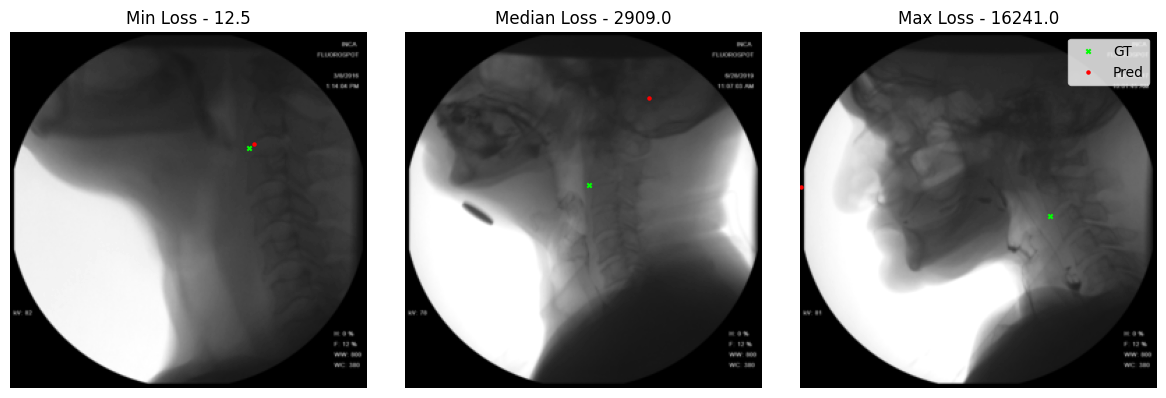

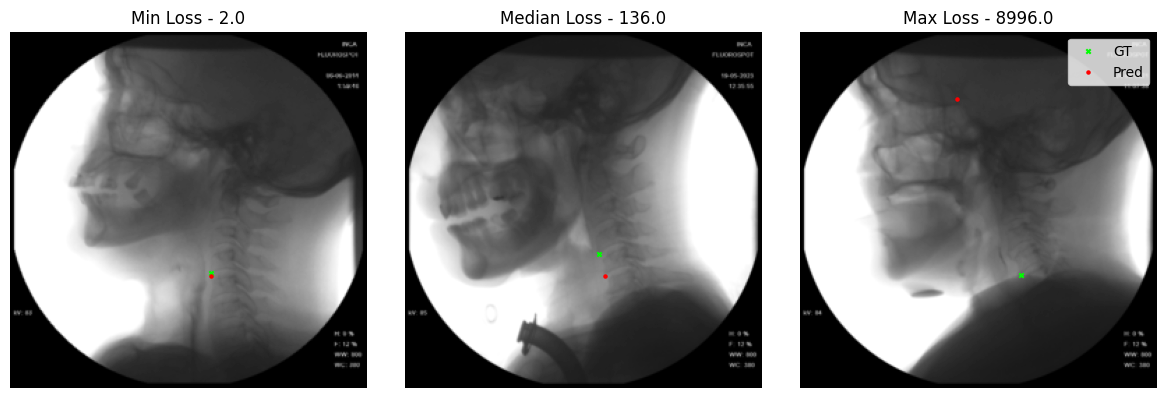

In [18]:
# Teste - PoseNet
for i in range(1):
    model_path = f"..\\..\\data\\model_weights\\posenet\\posenet_checkpoint_fold{i+1}.pth.tar"
    path_figure = f"..\\..\\data\\vis\\posenet\\fold{i+1}"
    criterion = nn.MSELoss()
    model_kwargs = {
        "num_keypoints": 2,
    }
    visualizacao_resultados_teste_posenet(test_data = test_data,
                                model_class = PoseNet,
                                model_kwargs = model_kwargs,
                                model_path = model_path,
                                path_figure = path_figure,
                                criterion = criterion,
                                device = device)